In [1]:
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from pylab import rcParams
import os
import re
%matplotlib inline
from sklearn.cluster import KMeans

# Imported the inaugural corpus from nltk.corpus
import nltk
from nltk.corpus import inaugural
from nltk.tokenize import regexp_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

import gensim
from gensim.utils import simple_preprocess
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
import inflect
p = inflect.engine()
import num2words
from num2words import num2words
import time
# from time import time


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rkothari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('/home/rkothari/Downloads/mix_match_done.csv',sep=',')

In [3]:
data.columns

Index(['Unnamed: 0', 'STYLE_NAME', 'STLYE', 'CT'], dtype='object')

In [4]:
product_description = pd.DataFrame(data['STYLE_NAME'])

In [5]:
len(product_description)

68258

In [6]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize

word_lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')

def cleaned_text(text):
    print(text)
    word = nltk.tokenize.word_tokenize(text)
    
    word = [word_lemmatizer.lemmatize(w) for w in word]
    return(word)

In [7]:
tokenized_words = []
for desc in data["STYLE_NAME"]:
    
    tokenized_words.append(nltk.tokenize.word_tokenize(desc))

In [8]:
len(tokenized_words)

68258

In [9]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
num_features = 100
# Used TaggedDocument to input for Doc2Vec model and calculated the document vectors to use as a input for the models
desc = [TaggedDocument(doc, [i]) for i, doc in enumerate(tokenized_words)]
doc2vec_model = Doc2Vec(desc, size = num_features, window = 8, min_count = 2, workers = 7)
doc2vec_model.train(desc, total_examples = doc2vec_model.corpus_count, epochs = 10)
document_vectors = doc2vec_model.docvecs.vectors_docs

## WORD2VEC

In [47]:
# Created a tokenized corpus for the word2vec model
tokenized_list = [simple_preprocess(heading) for heading in data["STYLE_NAME"]]
tokenized_corpus = np.array(tokenized_list)
num_features = 100

word2vec_model = Word2Vec(tokenized_corpus, size = num_features, window = 8, min_count = 2, sample = 1e-3, sg = 1, iter = 5, workers = 8)
vocabulary = set(word2vec_model.wv.index2word)


In [10]:
vocabulary = set(doc2vec_model.wv.index2word)


In [11]:
# Used a function to calculate the average word vectors and stored them as an array input
def calculateAverageWordVector(tokens, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.
    for word in tokens:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
    return feature_vector

tokenized_features = [calculateAverageWordVector(tokens, doc2vec_model, vocabulary, num_features) for tokens in tokenized_words]
avg_tokenized_features = np.array(tokenized_features)

In [48]:
## WORD2VEC

tokenized_features_WORD2VEC = [calculateAverageWordVector(tokens, word2vec_model, vocabulary, num_features) for tokens in tokenized_corpus]
avg_tokenized_features_WORD2VEC = np.array(tokenized_features)

In [67]:
# As we can see from the above elbow curve, the optimum number of clusters is 2
number_of_clusters = 4


def createClusters(corpus, num_clusters, isKMeans):
    if isKMeans == True:
        model = KMeans(n_clusters = number_of_clusters)
        model = model.fit(corpus)
    model_labels = model.labels_
    clusters = model_labels.tolist()
    return clusters

In [68]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS, TSNE

# Used a function that takes the corpus, number of clusters, and two boolean flags as input
# The function calculates distances and two types of manifolds as per an input boolean flag
def plotClusters(corpus, num_clusters, isKMeans, isMDS):
    distance = ''
    if isMDS == True:
        distance = 1 - cosine_similarity(corpus[0:10000])
        manifold = MDS(n_components = 2, dissimilarity = "precomputed", random_state = 95)
    else:
        distance = corpus[0:10000]
        manifold = TSNE(n_components = 2, init = 'random', random_state = 95, perplexity=50)
    pos = manifold.fit_transform(distance)
    xs, ys = pos[:, 0], pos[:, 1]

    # Set up cluster names using a dict
    cluster_names = {0: 'Cluster 1', 1: 'Cluster 2', 2: 'Cluster 3', 3: 'Cluster 4'}
    cluster_colors = {0: '#6DB31F', 1: '#F83F1D', 2: '#1DB9F8', 3: '#F26FCF'}

    # Created a dataframe which calls the createClusters method for labels, 
    # Grouped them by the labels and plotted the clusters
    cluster_plot_df = pd.DataFrame(dict(x = xs, y = ys, label = createClusters(corpus, num_clusters, isKMeans)[0:10000])) 
    cluster_groups = cluster_plot_df.groupby('label')
    fig, ax = plt.subplots(figsize=(17, 8))

    for name, group in cluster_groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=20, 
                label=cluster_names[name], color=cluster_colors[name], mec='none')
        ax.set_aspect('auto')
        ax.tick_params(axis= 'x',  which='both', bottom='off', top='off', labelbottom='off')
        ax.tick_params(axis= 'y', which='both', left='off', top='off', labelleft='off')
    ax.legend(numpoints=1) 
    plt.show()

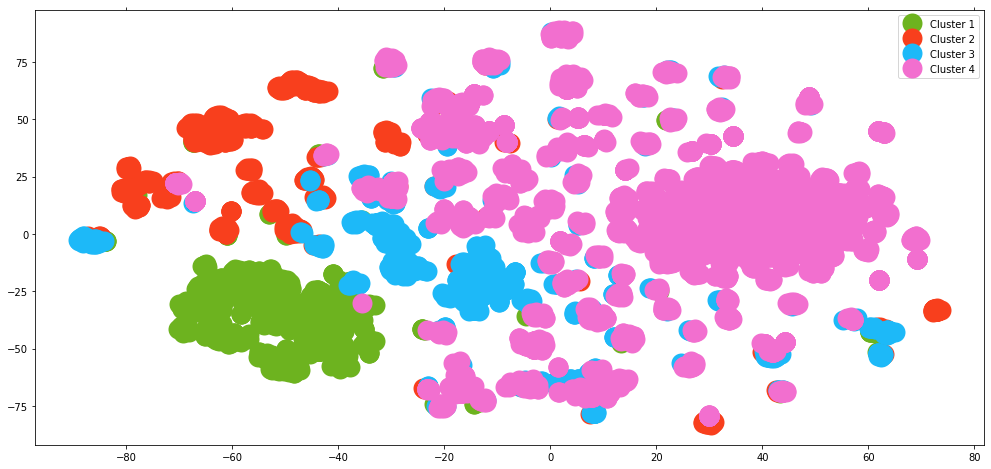

In [69]:
plotClusters(tokenized_features, number_of_clusters, isKMeans = True, isMDS = False)


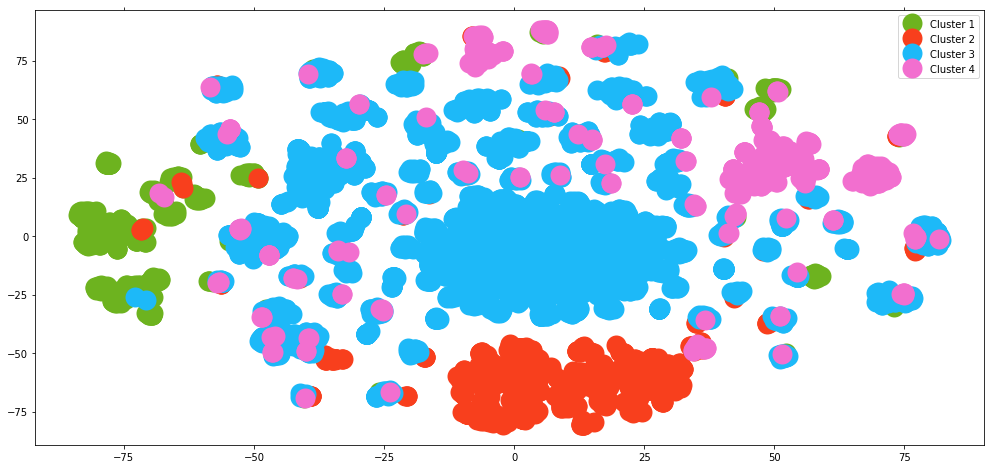

In [70]:
plotClusters(tokenized_features_WORD2VEC,number_of_clusters, isKMeans = True, isMDS = False)
